# Mushroom Classification

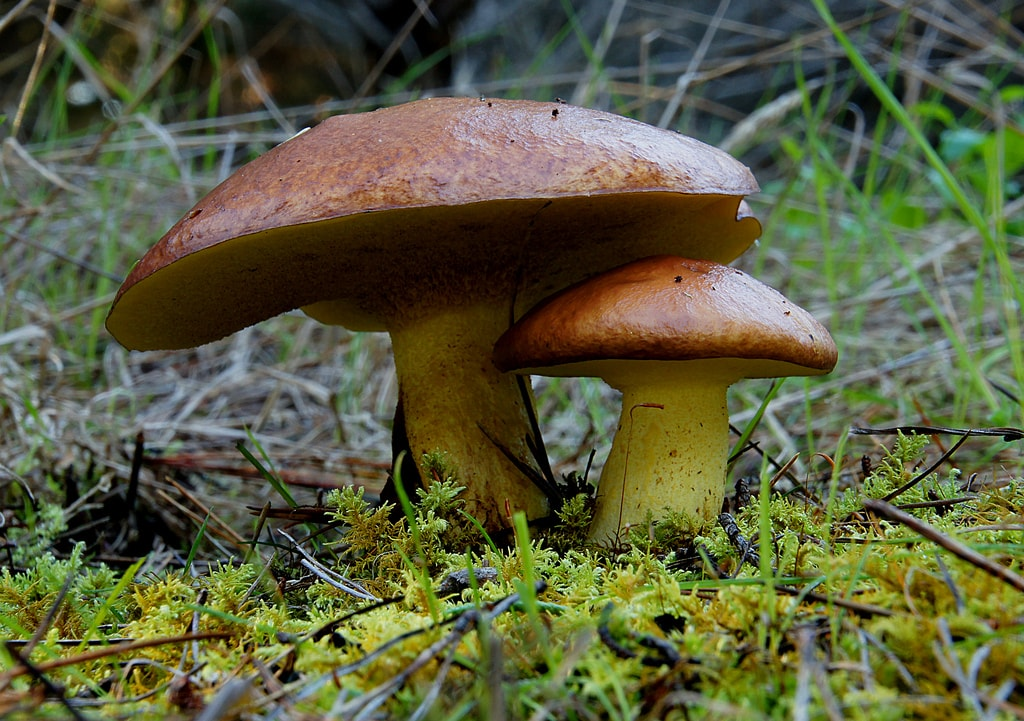

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

First we will import all the required libraries.

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Now we will check the version of the tensorflow that is being imported.

In [ ]:
print(tf.__version__)

Now we will have a look at the dataset.

In [ ]:
data = pd.read_csv("/kaggle/input/mushroom-classification/mushrooms.csv")
data.head()

In [ ]:
data.shape

In [ ]:
data.dtypes

And as can be seen all the variables are categorical in nature.

Now we will check whether our dataset has any missing values or not.

In [ ]:
data.isnull().sum()

In [ ]:
data["veil-type"].value_counts()

In [ ]:
data.drop(columns=["veil-type"],inplace=True)

Here we will remove the veil-type feature, as it has only one level, so it is not useful for the model, so we will remove this.

**Now let's check whether our dataset is balanced or not.**

In [ ]:
plt.style.use("ggplot")
data["class"].value_counts().plot(kind="bar", 
                                  figsize = (8,5), color = "darkviolet")
plt.title("Frequency of the classes of our Target variable", size=20)
plt.xlabel("Target Variable", size = 16)
plt.ylabel("Frequency", size = 16)

So as can be seen from the visualization, our dataset seems pretty balanced.

In [ ]:
data.shape

In [ ]:
X = data.drop(columns=["class"], axis = 1)
y = data["class"]

# Feature Selection


Feature selection is important here as still after the removal of "veil-type", there are 22 variables, and after creating creating dummies for these categorical variables, the number of variables is bound to increase, so we need to find a way to remove some of the insignificant variables, and we will do it using **Chi-Squared Feature Selection**, but before that we need to convert the all the input variables into ordinal format. But before doing anything else, we will first split the dataset into train and test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [ ]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

In [ ]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

Now we will do actual feature selection.

In [ ]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)

In [ ]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.figure(figsize = (12,6))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title("Feature Importance Score", size = 20)
plt.xlabel("Features/ Variables", size = 16, color = "black")
plt.ylabel("Importance Score", size = 16, color = "black")
plt.show()

In [ ]:
X_train.columns

**Here we will select features with higher importance score.** So by looking at them we may select feature (1, 3, 6, 7, 8, 10, 11, 12, 17, 18, 19 and 20). Basically I have selected feature with importance score of more than 100, there is no rule that you have to do selection in this way only, it is completely on you what importance score you chose as a deciding factor, but one has to take the features with higher score.

Now we'll actually see what are those features, I mean let's see the name of the features, and to see the names I used the above piece of code. They are:- 

1 - "cap-shape"

3 - "bruises"

6 - "gill-spacing"

7 - "gill-size"

8 - "gill-color"

10 - "stalk-root"

11 - "stalk-surface-above-ring

12 - "stalk-surface-below-ring"

17 - "ring-type"

18 - "spore-print-color"

19 - "population"

20 - "habitat"

So now the number of variables/features has reduced from 21 to 12, which is good, so now we will build our model with these 12 features.

# Data Preparation for NN Model

Now before feeding these variables to the neural network, we will create dummies for all the variables which we just selected from the above procedure. So in the below piece of code we will drop all the other variables, and take only those which we selected from the feature selection mechanism.

In [ ]:
X_new = X.drop(columns = ["cap-surface", "cap-color", "odor", "gill-attachment", "stalk-shape",
                         "stalk-color-above-ring", "stalk-color-below-ring", "veil-color", "ring-number"])

In [ ]:
X_dummies = pd.get_dummies(X_new, drop_first=True, columns = ["cap-shape", "bruises",
                                                          "gill-spacing", "gill-size", "gill-color",
                                                          "stalk-root", "stalk-surface-above-ring",
                                                          "stalk-surface-below-ring", "ring-type",
                                                          "spore-print-color", "population", "habitat"])

In [ ]:
X_dummies.shape

So after dummy creation, total number of our features is now 52, earlier before feature selection, it was 95. We can see the names if we want by the below piece of code.

In [ ]:
X_dummies.columns

Now we will split the data into train and test, and our splitting size will be 80-20. But before that let's encode our target feature, we are not using the above encoded one, because we have use it in the feature selection, so for precaution purpose we will create another variable as y_encoded, and put the encoded target variable there.

In [ ]:
label = LabelEncoder()
data["class_2"]=label.fit_transform(data["class"])
y_encoded = data["class_2"]

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_dummies, y_encoded, test_size = 0.2, random_state = 0, stratify = y_encoded)

In [ ]:
X_train_2.shape

# Model Architecture

Now we will create our NN model, which contains 2 hidden layers with 16 units each, as can be seen in the below code, and the activation function we will be using for the hidden layers are "relu", and "sigmoid" for the output layer.

In [ ]:
model = Sequential()
model.add(Dense(X_dummies.shape[1], activation = 'relu', input_dim = X_dummies.shape[1]))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Model Compilation

Also we will be using "adam" optimizer algorithm, and "binary_crossentropy" as loss function.

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Finally we will train the model, with batch size 1024, and number of epochs as 15. Always remember batch size and epochs are the two important hyperparameters, if you don't chose these values correctly, then either you may overfit the model, or you may underfit the model. So you have to be pretty careful with that.

# Model Fitting

Also just after fitting the model, we will try to visualize how the accuracy has gone up after 15 epochs, and we will also check for the loss, i.e., how it has gone down.

In [ ]:
history = model.fit(X_train_2, y_train_2, batch_size = 1024, epochs = 15, validation_data=(X_test_2, y_test_2), verbose = 1)

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

In [ ]:
plotLearningCurve(history,15)

Now we will predict the result.

In [ ]:
y_pred = model.predict_classes(X_test_2)

In [ ]:
cm=confusion_matrix(y_test_2, y_pred)
cm

# Model Performance

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt = 'g', cmap="Reds", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting", size = 20)

Now let's see other evaluating paramters.

In [ ]:
print(classification_report(y_test_2, y_pred))

**Note: Also very soon I am planning to work on this same dataset using "PyTorch"**